In [1]:
import librosa
import librosa.display
from librosa.core import load
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

VERSION = 4 # input file version

## Load data

In [2]:
# master_data = pd.read_csv(f'./dataset_info_combined_V{VERSION}.csv')
df_joint_train = pd.read_csv(f'./features/cache_all_features_train_V{VERSION}_augmented_1547features.csv')
feature_column_names = [i for i in df_joint_train.columns \
                        if i not in ['file_path','renamed_file_path','split','sentiment_value','emotional_category']]

print("shape of train set: ", df_joint_train.shape)

shape of train set:  (13904, 1547)


In [5]:
feature_intensity = ['Intensity_min_intensity', 'Intensity_relative_min_intensity_time', 'Intensity_max_intensity', 'Intensity_relative_max_intensity_time', 'Intensity_mean_intensity', 'Intensity_stddev_intensity', 'Intensity_q1_intensity', 'Intensity_median_intensity', 'Intensity_q3_intensity'] 
feature_pitch     = ['Pitch_voiced_fraction', 'Pitch_min_pitch', 'Pitch_relative_min_pitch_time', 'Pitch_max_pitch', 'Pitch_relative_max_pitch_time', 'Pitch_mean_pitch', 'Pitch_stddev_pitch', 'Pitch_q1_pitch', 'Pitch_median_intensity', 'Pitch_q3_pitch', 'Pitch_mean_absolute_pitch_slope', 'Pitch_pitch_slope_without_octave_jumps'] 
feature_GNE       = ['GNE_max_gne', 'GNE_mean_gne', 'GNE_stddev_gne', 'GNE_sum_gne']
feature_HNR       = ['HNR_min_hnr','HNR_relative_min_hnr_time', 'HNR_max_hnr', 'HNR_relative_max_hnr_time', 'HNR_mean_hnr', 'HNR_stddev_hnr']
feature_spect     = ['Spectrum_band_energy', 'Spectrum_band_density', 'Spectrum_band_energy_difference', 'Spectrum_band_density_difference', 'Spectrum_center_of_gravity_spectrum', 'Spectrum_stddev_spectrum', 'Spectrum_skewness_spectrum', 'Spectrum_kurtosis_spectrum', 'Spectrum_central_moment_spectrum'] 
feature_formant   = ['Formant_f1_mean', 'Formant_f2_mean', 'Formant_f3_mean', 'Formant_f4_mean', 'Formant_f1_median', 'Formant_f2_median', 'Formant_f3_median', 'Formant_f4_median', 'Formant_formant_dispersion', 'Formant_average_formant', 'Formant_mff', 'Formant_fitch_vtl', 'Formant_delta_f', 'Formant_vtl_delta_f'] 
feature_local     = ['Local Jitter', 'Local Shimmer']
feature_names_prosody = feature_intensity+feature_pitch+feature_HNR+feature_spect+ feature_formant+feature_local
print(len(feature_names_prosody))

52


In [6]:
X = df_joint_train[feature_names_prosody]
y_s = df_joint_train['sentiment_value']
y_e = df_joint_train['emotional_category']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_e_num = label_encoder.fit_transform(y_e)

### ANOVA F Test + Coorelation +  mutal info + feature-feature correlation

In [7]:
# Create an array to store correlations
correlations = np.zeros(X.shape[1])  
for i in range(X.shape[1]):
    correlations[i] = np.corrcoef(X.iloc[:, i], y_e_num)[0, 1]
# print("Correlation coefficients between each feature and the labels:\n", correlations)

# to compute some form of association between categorical labels and numerical features, 
# you could consider using chi-squared tests for independence or mutual information scores.
from sklearn.feature_selection import mutual_info_classif
mutual_info_scores = mutual_info_classif(X, y_e)
# print("Mutual Information scores:\n", mutual_info_scores)

# For feature-feature correlation
feature_corr_matrix = np.corrcoef(X.T)

# ANOVA F-test with p-values
anova_selector = SelectKBest(f_classif, k='all')
anova_selector.fit(X, y_e)
p_values = anova_selector.pvalues_
f_scores = anova_selector.scores_
is_significant_p = (p_values < 0.05).astype(int)  
# ranking_by_f_score = np.argsort(f_scores)

# Combine results into a single dataframe
result_df = pd.DataFrame({
    'feature': feature_names_prosody,
    'p_value': p_values,
    'is_significant': is_significant_p,
    'f_score': f_scores,
    'correlation_coeff': correlations,
    'mutual_info_score': mutual_info_scores
})

result_df = result_df.round(4).sort_values(by='f_score',ascending=False)
# result_df.head()
result_df.to_csv(f'./features/relationship_stats_test_result_emotion_prosody_V{VERSION}_augmented.csv',index = False)

#### correlation plot (must select part of features) 

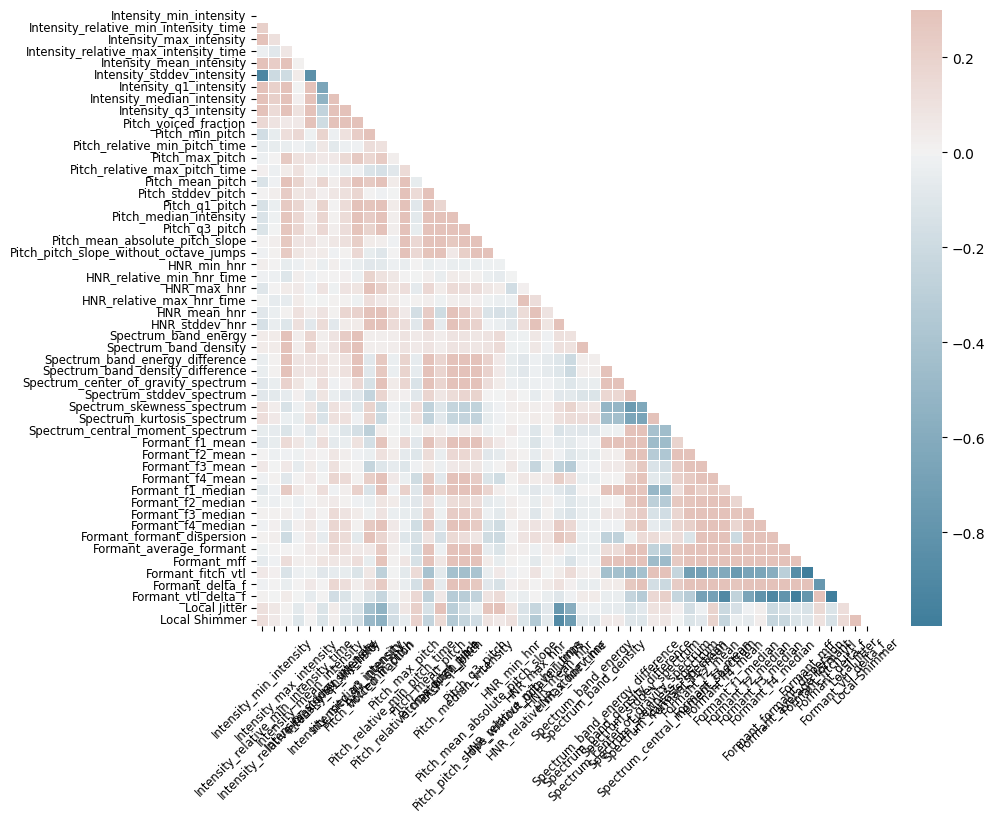

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a mask to hide the upper triangle since it's redundant with the lower triangle
mask = np.triu(np.ones_like(feature_corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Make sure the length of column_name_original matches the number of features in your correlation matrix
assert len(feature_names_prosody) == feature_corr_matrix.shape[0]

# Generate the heatmap with custom labels and show the diagonal
sns.heatmap(feature_corr_matrix,  mask=mask, cmap=cmap, vmax=.3, center=0, annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": .2},
            xticklabels=feature_names_prosody, yticklabels=feature_names_prosody)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize='small')
plt.yticks(fontsize='small')

plt.show()

### Use Sentiment Label

In [12]:
# Create an array to store correlations
correlations = np.zeros(X.shape[1])  
for i in range(X.shape[1]):
    correlations[i] = np.corrcoef(X.iloc[:, i], y_s)[0, 1]

from sklearn.feature_selection import mutual_info_classif
mutual_info_scores = mutual_info_classif(X, y_s)
print("Mutual Information scores:\n", mutual_info_scores)

# ANOVA F-test with p-values
anova_selector = SelectKBest(f_classif, k='all')
anova_selector.fit(X, y_s)
p_values = anova_selector.pvalues_
f_scores = anova_selector.scores_
is_significant_p = (p_values < 0.05).astype(int)  

result_df = pd.DataFrame({
    'feature': feature_names_prosody,
    'p_value': p_values,
    'is_significant': is_significant_p,
    'f_score': f_scores,
    'correlation_coeff': correlations,
    'mutual_info_score': mutual_info_scores
})

result_df = result_df.round(4).sort_values(by='f_score',ascending=False)

result_df.to_csv(f'./features/relationship_stats_test_result_sentiment_prosody_V{VERSION}_augmented.csv',index = False)
result_df.head()

Mutual Information scores:
 [0.02392932 0.01011267 0.10894212 0.04736346 0.07781354 0.07952665
 0.01824348 0.05425578 0.09827554 0.02830736 0.07020555 0.01627164
 0.16415302 0.02812702 0.23105605 0.14398744 0.135953   0.18406879
 0.24034101 0.15777846 0.14050488 0.00792274 0.03206629 0.
 0.0088837  0.03530237 0.00228179 0.10840635 0.09883539 0.08547547
 0.08542307 0.07617314 0.02415227 0.03867346 0.03277024 0.01632894
 0.03457926 0.00163389 0.01157629 0.00083297 0.04590421 0.00693953
 0.00522922 0.01844145 0.02462299 0.00432184 0.00982258 0.01574842
 0.00607101 0.00611516 0.04186714 0.01423267]


,feature,p_value,is_significant,f_score,correlation_coeff,mutual_info_score
18,Pitch_q3_pitch,0.0,1,3284.6453,0.4457,0.2403
14,Pitch_mean_pitch,0.0,1,2929.3497,0.4240,0.2311
20,Pitch_pitch_slope_without_octave_jumps,0.0,1,2145.2770,0.4111,0.1405
17,Pitch_median_intensity,0.0,1,2110.3442,0.3680,0.1841
19,Pitch_mean_absolute_pitch_slope,0.0,1,2101.7770,0.4066,0.1578


In [13]:
result_df.describe()

,p_value,is_significant,f_score,correlation_coeff,mutual_info_score
count,52.000000,52.0,52.000000,52.000000,52.000000
mean,0.000010,1.0,507.117058,0.091315,0.056919
std,0.000057,0.0,805.488797,0.162507,0.060862
min,0.000000,1.0,7.782200,-0.150500,0.000000
25%,0.000000,1.0,31.890575,-0.031700,0.011225
50%,0.000000,1.0,126.505350,0.049000,0.032450
75%,0.000000,1.0,591.604775,0.195025,0.085425
max,0.000400,1.0,3284.645300,0.445700,0.240300
